In [49]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


primary_fuel_transformed
Other                       18859
Solar                       10664
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

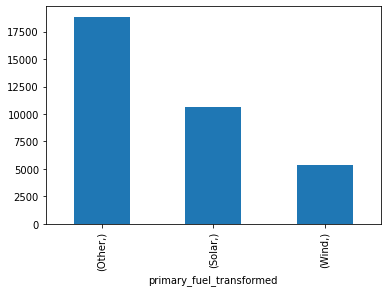

In [2]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])
# df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v5_transformed_data_combined_with_nasa.csv", index_col=['index'])
# csv_power_plants.loc[0:34935, ['capacity_mw', 'primary_fuel_transformed']].index.name = "index"
csv_power_plants.index.rename('index', inplace=True)
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

index_set_to_delete = csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

csv_power_plants.drop(index_set_to_delete, inplace = True)
columns_to_combine = [
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:24360, ['capacity_mw', 'primary_fuel_transformed']],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [7]:
df_solar = df_transformed_combined[df_transformed_combined['primary_fuel_transformed']== "Solar"]

In [9]:
utils.calculate_feature_mean_std(df_solar)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/src/utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'mean_{season_feature}']= X[dict_season_feature[season_feature]].mean(axis=1)
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/src/utils.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'std_{season_feature}']= X[dict_season_feature[season_feature]].std(axis=1)
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/src/utils.py:1

In [15]:
columns_delete = df_solar.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') |  df_solar.columns.str.contains('ANN') |  df_solar.columns.str.contains('LW') |  df_solar.columns.str.contains('WS10') | df_solar.columns.str.contains('MAX')
df_solar_2 = df_solar.loc[:,~columns_delete]

In [17]:
df_solar_2.columns

Index(['capacity_mw', 'mean_spring_ALLSKY_SFC_SW_DWN',
       'std_spring_ALLSKY_SFC_SW_DWN', 'mean_winter_ALLSKY_SFC_SW_DWN',
       'std_winter_ALLSKY_SFC_SW_DWN', 'mean_summer_ALLSKY_SFC_SW_DWN',
       'std_summer_ALLSKY_SFC_SW_DWN', 'mean_autumn_ALLSKY_SFC_SW_DWN',
       'std_autumn_ALLSKY_SFC_SW_DWN', 'mean_spring_ALLSKY_SFC_SW_DNI',
       'std_spring_ALLSKY_SFC_SW_DNI', 'mean_winter_ALLSKY_SFC_SW_DNI',
       'std_winter_ALLSKY_SFC_SW_DNI', 'mean_summer_ALLSKY_SFC_SW_DNI',
       'std_summer_ALLSKY_SFC_SW_DNI', 'mean_autumn_ALLSKY_SFC_SW_DNI',
       'std_autumn_ALLSKY_SFC_SW_DNI', 'mean_spring_WS50M', 'std_spring_WS50M',
       'mean_winter_WS50M', 'std_winter_WS50M', 'mean_summer_WS50M',
       'std_summer_WS50M', 'mean_autumn_WS50M', 'std_autumn_WS50M',
       'mean_spring_T2M', 'std_spring_T2M', 'mean_winter_T2M',
       'std_winter_T2M', 'mean_summer_T2M', 'std_summer_T2M',
       'mean_autumn_T2M', 'std_autumn_T2M', 'mean_spring_CLRSKY_SFC_SW_DNI',
       'std_spring_CLR

In [23]:
df_solar_2['capacity_mw'].isna().sum()

0

In [20]:
X = df_solar_2.drop(columns=['capacity_mw'])
y = df_solar_2['capacity_mw']

In [35]:
y.describe()

count    10664.000000
mean        17.651099
std         41.936892
min          1.000000
25%          2.600000
50%          5.800000
75%         18.000000
max       1021.000000
Name: capacity_mw, dtype: float64

<AxesSubplot:>

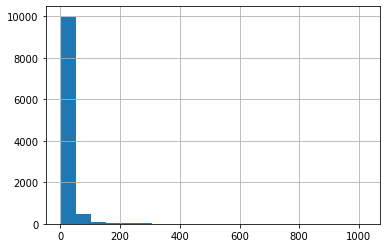

In [81]:
df_solar_2['capacity_mw'].hist(bins=20)

<AxesSubplot:>

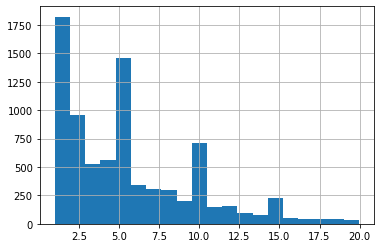

In [82]:
df_solar_2[df_solar_2['capacity_mw'] < 20]['capacity_mw'].hist(bins=20)

<AxesSubplot:>

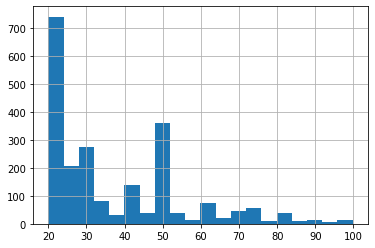

In [83]:
df_solar_2.loc[(df_solar_2['capacity_mw'] >= 20) & (df_solar_2['capacity_mw'] < 100)]['capacity_mw'].hist(bins=20)

<AxesSubplot:>

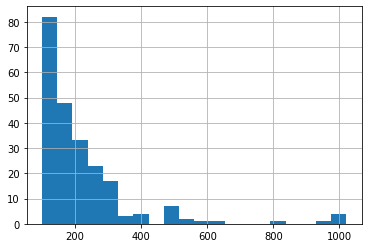

In [84]:
df_solar_2[df_solar_2['capacity_mw'] > 100]['capacity_mw'].hist(bins=20)

In [46]:
# remove high values???
df_solar_2['capacity_mw'].sort_values(ascending= False)

index
18177    1021.0
5583     1000.0
6824     1000.0
8870     1000.0
8501      971.0
6422      820.0
14774     648.0
33431     585.9
14252     560.0
7451      530.0
497       500.0
5622      500.0
15052     500.0
5094      500.0
14720     500.0
5972      500.0
8768      500.0
14240     420.0
34746     420.0
18230     400.0
Name: capacity_mw, dtype: float64

In [47]:
df_solar.loc[18177, ["latitude", "longitude", "capacity_mw"]]

latitude        18.35
longitude       55.71
capacity_mw    1021.0
Name: 18177, dtype: object

In [24]:
X = X.reindex(sorted(X.columns), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 0)

# DECISION TREE REGRESSOR

In [28]:

# Define model. Specify a number for random_state to ensure same results each run
tree_model = DecisionTreeRegressor(random_state=1)

# Fit model
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [29]:
y_pred = tree_model.predict(X_test)

In [30]:

print(mean_absolute_error(y_test, y_pred))

14.934280380638032


# RANDOM FOREST REGRESSOR

In [50]:
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

13.834475751291556
